#################### Anomaly Classification using Supervised Machine Learning in Pill category of MVTec dataset ############ 

In [4]:
import os
import warnings
import time
import cv2
import numpy as np
import seaborn as sns
from PIL import Image
from skimage.feature import hog
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
warnings.filterwarnings("ignore")

# load MVTec images from a specific category structure
def load_mvtec_images(path, label):
    images = []
    labels = []
    for root, _, files in os.walk(path):
        for file in files:
            if file.endswith('.png') or file.endswith('.jpg'):
                img = Image.open(os.path.join(root, file)).convert('RGB')
                img = img.resize((128, 128))
                images.append(np.array(img))
                labels.append(label)
    return np.array(images), np.array(labels).reshape(-1, 1)

# Load normal and anomalous images for a given category
def load_data(category, dataset_root='dataset/MVTec'):
    category_path = os.path.join(dataset_root, category)
    train_good_path = os.path.join(category_path, 'train', 'good')
    test_path = os.path.join(category_path, 'test')

    normal_images = []
    normal_labels = []

    # Load normal images from train/good
    print(f"Loading normal images from {train_good_path}...")
    train_normal_images, train_normal_labels = load_mvtec_images(train_good_path, 0)
    print(f"Loaded {len(train_normal_images)} normal images from {train_good_path}")
    normal_images.append(train_normal_images)
    normal_labels.append(train_normal_labels)

    # Load normal images from test/good
    test_good_path = os.path.join(test_path, 'good')
    print(f"Loading normal images from {test_good_path}...")
    test_normal_images, test_normal_labels = load_mvtec_images(test_good_path, 0)
    print(f"Loaded {len(test_normal_images)} normal images from {test_good_path}")
    normal_images.append(test_normal_images)
    normal_labels.append(test_normal_labels)

    normal_images = np.concatenate(normal_images)
    normal_labels = np.concatenate(normal_labels)

    anomalous_images = []
    anomalous_labels = []

    # Load anomalous images from all subfolders in test, except 'good'
    for subfolder in os.listdir(test_path):
        subfolder_path = os.path.join(test_path, subfolder)
        if os.path.isdir(subfolder_path) and subfolder != 'good':
            print(f"Loading anomalous images from {subfolder_path}...")
            anomaly_images, anomaly_labels = load_mvtec_images(subfolder_path, 1)
            print(f"Loaded {len(anomaly_images)} anomalous images from {subfolder_path}")
            anomalous_images.append(anomaly_images)
            anomalous_labels.append(anomaly_labels)

    anomalous_images = np.concatenate(anomalous_images)
    anomalous_labels = np.concatenate(anomalous_labels)

    print(f"Total normal images loaded: {len(normal_images)}")
    print(f"Total anomalous images loaded: {len(anomalous_images)}")

    return normal_images, normal_labels, anomalous_images, anomalous_labels

category = 'pill'
normal_images, normal_labels, anomalous_images, anomalous_labels = load_data(category)
print("\nExtracted features data shapes:")
print("Extracted_good_images:", normal_images.shape, normal_labels.shape)
print("Extracted_anomalous_images:", anomalous_images.shape, anomalous_labels.shape)


Loading normal images from dataset/MVTec\pill\train\good...
Loaded 267 normal images from dataset/MVTec\pill\train\good
Loading normal images from dataset/MVTec\pill\test\good...
Loaded 26 normal images from dataset/MVTec\pill\test\good
Loading anomalous images from dataset/MVTec\pill\test\color...
Loaded 25 anomalous images from dataset/MVTec\pill\test\color
Loading anomalous images from dataset/MVTec\pill\test\combined...
Loaded 17 anomalous images from dataset/MVTec\pill\test\combined
Loading anomalous images from dataset/MVTec\pill\test\contamination...
Loaded 21 anomalous images from dataset/MVTec\pill\test\contamination
Loading anomalous images from dataset/MVTec\pill\test\crack...
Loaded 26 anomalous images from dataset/MVTec\pill\test\crack
Loading anomalous images from dataset/MVTec\pill\test\faulty_imprint...
Loaded 19 anomalous images from dataset/MVTec\pill\test\faulty_imprint
Loading anomalous images from dataset/MVTec\pill\test\pill_type...
Loaded 9 anomalous images from 

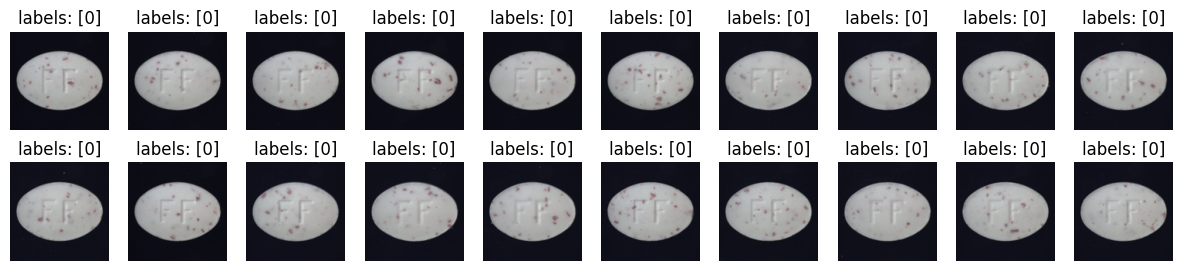

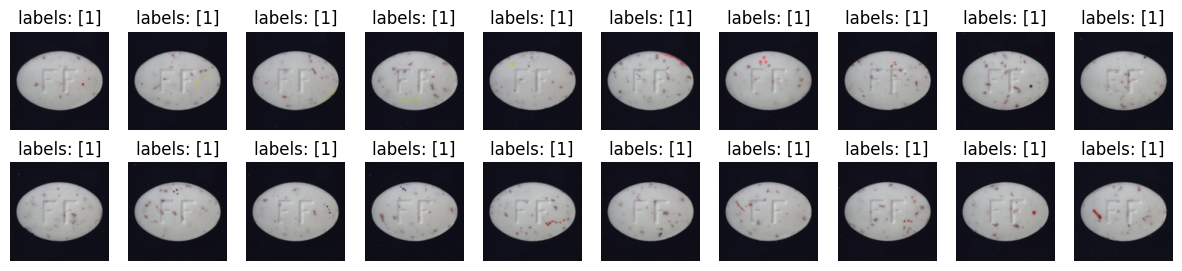

In [5]:
def plot_data(normal_images, normal_labels, n=100):
    num_rows = n // 10
    fig, axs = plt.subplots(num_rows, 10, figsize=(15, 1.5 * num_rows), gridspec_kw={'hspace': 0.3})
    axs = axs.ravel()
    for i in range(n):
        axs[i].imshow(normal_images[i])
        axs[i].set_title(f"labels: {normal_labels[i]}")
        axs[i].axis("off")
    plt.show()

plot_data(normal_images, normal_labels, 20)
plot_data(anomalous_images, anomalous_labels, 20)



In [6]:
# HOG Feature Extraction
def extract_hog_features(images):
    hog_features = []
    for image in images:
        # Convert image to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # Resize image to 128x128
        resized_image = cv2.resize(gray_image, (128, 128))
        
        # Extract HOG features
        fd, _ = hog(resized_image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True)
        hog_features.append(fd)
    return np.array(hog_features)

# Assuming normal_images and anomalous_images are defined and contain paths to images or loaded images
normal_images_hog = extract_hog_features(normal_images)
anomalous_images_hog = extract_hog_features(anomalous_images)

print("\nExtracted HOG features data shapes:")
print("Extracted_good_images_hog:", normal_images_hog.shape, normal_labels.shape)
print("Extracted_anomalous_images_hog:", anomalous_images_hog.shape, anomalous_labels.shape)



Extracted HOG features data shapes:
Extracted_good_images_hog: (293, 512) (293, 1)
Extracted_anomalous_images_hog: (141, 512) (141, 1)


In [19]:
# Shuffle the features of each data
def shuffle_data(data, labels):
    idx = np.arange(data.shape[0])
    np.random.shuffle(idx)
    return data[idx], labels[idx]

normal_images_hog, normal_labels = shuffle_data(normal_images_hog, normal_labels)
anomalous_images_hog, anomalous_labels = shuffle_data(anomalous_images_hog, anomalous_labels)



In [20]:
# Scale the shuffeld data to be normalized
def min_max_scaling(data):
    min_val = np.min(data)
    max_val = np.max(data)
    scaled_data = (data - min_val) / (max_val - min_val)
    return scaled_data

normalized_images_hog = min_max_scaling(normal_images_hog)
normalized_anomalous_images_hog = min_max_scaling(anomalous_images_hog)


print("\nNormalized data shapes with HOG:")
print("normalized images using HOG:", normalized_images_hog.shape, normal_labels.shape)
print("normalized anomalous images using HOG:", normalized_anomalous_images_hog.shape, anomalous_labels.shape)




Normalized data shapes with HOG:
normalized images using HOG: (293, 512) (293, 1)
normalized anomalous images using HOG: (141, 512) (141, 1)


In [21]:
# Split data into training and testing sets for each feature extracted
X_combined_hog = np.concatenate((normalized_images_hog, normalized_anomalous_images_hog), axis=0)
y_combined_hog = np.concatenate((normal_labels, anomalous_labels), axis=0)

X_train_hog, X_test_hog, y_train_hog, y_test_hog = train_test_split(
X_combined_hog, y_combined_hog, test_size=0.2, random_state=42, stratify=y_combined_hog
)




In [22]:
# Dimensionality reduction using PCA
def PCA(train_data, alpha=0.95):
    mean = np.mean(train_data, axis=0)
    centered_data = train_data - mean
    cov_matrix = np.dot(centered_data.T, centered_data)
    eig_values, eig_vectors = np.linalg.eigh(cov_matrix)
    idx = np.argsort(eig_values)[::-1]
    eig_values = eig_values[idx]
    eig_vectors = eig_vectors[:, idx]
    total = np.sum(eig_values)
    k = 0
    var = 0
    while var / total < alpha:
        var += eig_values[k]
        k += 1
    eig_vectors = eig_vectors[:, :k]
    return eig_vectors, mean



In [23]:
# Dimensionality reduction using LDA
def LDA(train_data, train_labels, k=1, regularization=1e-5):
    mean1 = np.mean(train_data[train_labels.ravel() == 1], axis=0)
    mean0 = np.mean(train_data[train_labels.ravel() == 0], axis=0)
    Sw = np.dot((train_data[train_labels.ravel() == 1] - mean1).T, (train_data[train_labels.ravel() == 1] - mean1)) + \
         np.dot((train_data[train_labels.ravel() == 0] - mean0).T, (train_data[train_labels.ravel() == 0] - mean0))
    Sw += np.eye(Sw.shape[0]) * regularization  # Add regularization
    Sb = np.dot((mean1 - mean0).reshape(-1, 1), (mean1 - mean0).reshape(-1, 1).T)
    eig_values, eig_vectors = np.linalg.eigh(np.dot(np.linalg.inv(Sw), Sb))
    idx = np.argsort(eig_values)[::-1]
    eig_values = eig_values[idx]
    eig_vectors = eig_vectors[:, idx]
    return eig_vectors[:, :k]



In [24]:
# Perform PCA on HOG features
space_pca_hog, mean_pca_hog = PCA(X_train_hog)
train_projected_pca_hog = np.dot(X_train_hog - mean_pca_hog, space_pca_hog)
test_projected_pca_hog = np.dot(X_test_hog - mean_pca_hog, space_pca_hog)

print("\nReduction features of HOG data shapes:")
print("Reduction_train_images_PCA:", train_projected_pca_hog.shape, normal_labels.shape)
print("Reduction_test_images_PCA:", test_projected_pca_hog.shape, anomalous_labels.shape)


Reduction features of HOG data shapes:
Reduction_train_images_PCA: (347, 168) (293, 1)
Reduction_test_images_PCA: (87, 168) (141, 1)


In [25]:
# Perform LDA on HOG features
lda_space_hog = LDA(X_train_hog, y_train_hog)
train_lda_projected_hog = np.dot(X_train_hog, lda_space_hog)
test_lda_projected_hog = np.dot(X_test_hog, lda_space_hog)

print("\nReduction features of HOG data shapes:")
print("Reduction_train_images_LDA:", train_lda_projected_hog.shape, normal_labels.shape)
print("Reduction_test_images_LDA:", test_lda_projected_hog.shape, anomalous_labels.shape)


Reduction features of HOG data shapes:
Reduction_train_images_LDA: (347, 1) (293, 1)
Reduction_test_images_LDA: (87, 1) (141, 1)


HOG Features - With HOG Feature Extraction - SVM
Training Time: 0.0267 seconds
Training Score: 98.5591
Testing Score: 80.4598
F1 Score: 0.8015
Cross-Validation Score: 83.5652
Best Hyperparameters - C: 10, Kernel: rbf


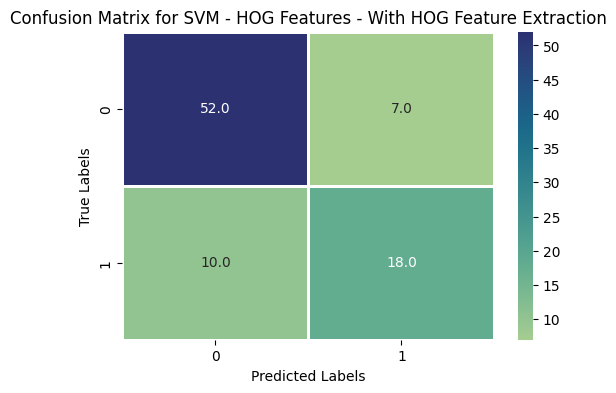

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86        59
           1       0.72      0.64      0.68        28

    accuracy                           0.80        87
   macro avg       0.78      0.76      0.77        87
weighted avg       0.80      0.80      0.80        87

------------------------------------------------------------------------------------------------------------------------
HOG Features - With_PCA - SVM
Training Time: 0.0163 seconds
Training Score: 100.0000
Testing Score: 82.7586
F1 Score: 0.8139
Cross-Validation Score: 87.3209
Best Hyperparameters - C: 10, Kernel: rbf


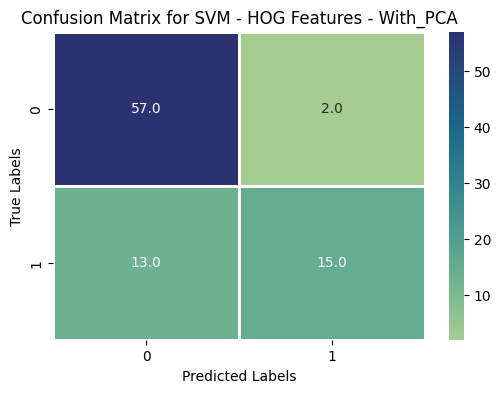

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.97      0.88        59
           1       0.88      0.54      0.67        28

    accuracy                           0.83        87
   macro avg       0.85      0.75      0.78        87
weighted avg       0.84      0.83      0.81        87

------------------------------------------------------------------------------------------------------------------------
HOG Features - With_LDA - SVM
Training Time: 0.0060 seconds
Training Score: 81.8444
Testing Score: 71.2644
F1 Score: 0.6953
Cross-Validation Score: 81.8344
Best Hyperparameters - C: 10, Kernel: rbf


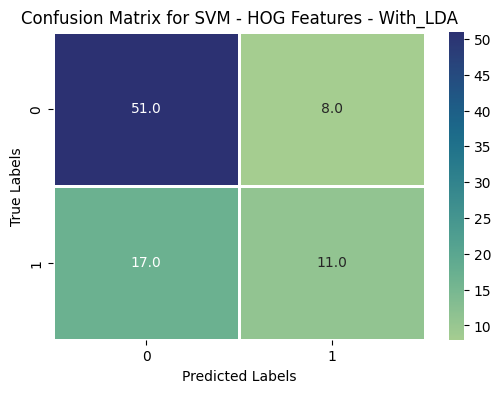

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.86      0.80        59
           1       0.58      0.39      0.47        28

    accuracy                           0.71        87
   macro avg       0.66      0.63      0.64        87
weighted avg       0.69      0.71      0.70        87

------------------------------------------------------------------------------------------------------------------------
HOG Features - With HOG Feature Extraction - KNN_Classifier
Training Time: 0.0000 seconds
Training Score: 91.6427
Testing Score: 77.0115
F1 Score: 0.7541
Cross-Validation Score: 82.4431
Best Hyperparameters - n_neighbors: 3


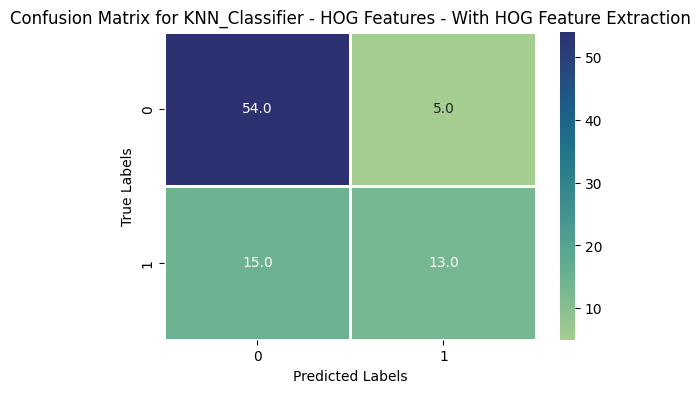

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.92      0.84        59
           1       0.72      0.46      0.57        28

    accuracy                           0.77        87
   macro avg       0.75      0.69      0.70        87
weighted avg       0.76      0.77      0.75        87

------------------------------------------------------------------------------------------------------------------------
HOG Features - With_PCA - KNN_Classifier
Training Time: 0.0010 seconds
Training Score: 91.0663
Testing Score: 75.8621
F1 Score: 0.7441
Cross-Validation Score: 82.1573
Best Hyperparameters - n_neighbors: 3


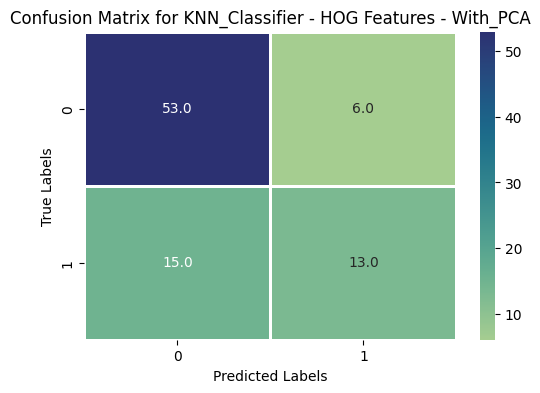

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.90      0.83        59
           1       0.68      0.46      0.55        28

    accuracy                           0.76        87
   macro avg       0.73      0.68      0.69        87
weighted avg       0.75      0.76      0.74        87

------------------------------------------------------------------------------------------------------------------------
HOG Features - With_LDA - KNN_Classifier
Training Time: 0.0010 seconds
Training Score: 85.0144
Testing Score: 70.1149
F1 Score: 0.6904
Cross-Validation Score: 80.6791
Best Hyperparameters - n_neighbors: 5


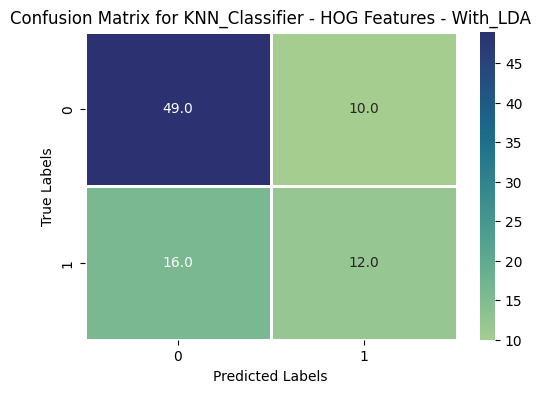

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.83      0.79        59
           1       0.55      0.43      0.48        28

    accuracy                           0.70        87
   macro avg       0.65      0.63      0.64        87
weighted avg       0.69      0.70      0.69        87

------------------------------------------------------------------------------------------------------------------------
HOG Features - With HOG Feature Extraction - Gaussian_NB
Training Time: 0.0040 seconds
Training Score: 90.2017
Testing Score: 77.0115
F1 Score: 0.7650
Cross-Validation Score: 78.1118


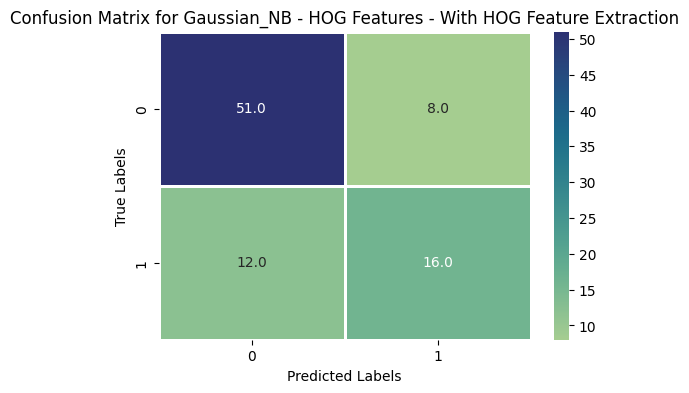

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.86      0.84        59
           1       0.67      0.57      0.62        28

    accuracy                           0.77        87
   macro avg       0.74      0.72      0.73        87
weighted avg       0.76      0.77      0.77        87

------------------------------------------------------------------------------------------------------------------------
HOG Features - With_PCA - Gaussian_NB
Training Time: 0.0020 seconds
Training Score: 93.6599
Testing Score: 70.1149
F1 Score: 0.6501
Cross-Validation Score: 70.8944


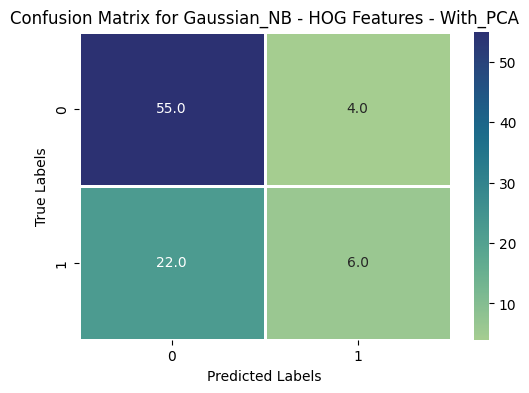

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.93      0.81        59
           1       0.60      0.21      0.32        28

    accuracy                           0.70        87
   macro avg       0.66      0.57      0.56        87
weighted avg       0.68      0.70      0.65        87

------------------------------------------------------------------------------------------------------------------------
HOG Features - With_LDA - Gaussian_NB
Training Time: 0.0000 seconds
Training Score: 80.6916
Testing Score: 68.9655
F1 Score: 0.6762
Cross-Validation Score: 80.4058


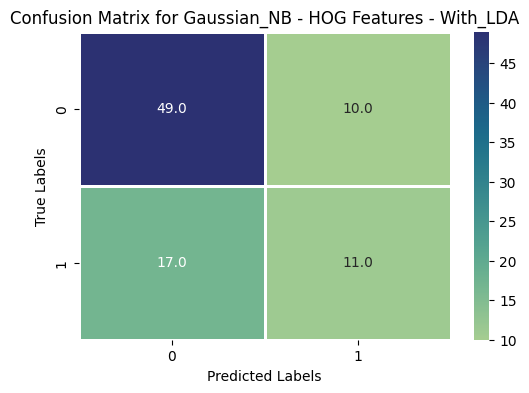

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.83      0.78        59
           1       0.52      0.39      0.45        28

    accuracy                           0.69        87
   macro avg       0.63      0.61      0.62        87
weighted avg       0.67      0.69      0.68        87

------------------------------------------------------------------------------------------------------------------------

The Best model is: SVM with With_PCA method, having an F1 score of 0.8139
Hyperparameters: C: 10, Kernel: rbf




In [26]:

# Create a list of classifier instances with hyperparameter grids for tuning
classifiers = [
    ("SVM", SVC(), {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'kernel': ['linear', 'rbf', 'poly', 'sigmoid']}),
    ("KNN_Classifier", KNeighborsClassifier(), {'n_neighbors': [3, 5, 7, 9]}),
    ("Gaussian_NB", GaussianNB(), {})
]

# Initialize lists to store classifier names, training accuracies, test accuracies, and F1-scores
classifier_names = []
train_accuracies = []
test_accuracies = []
f1_scores = []
training_times = []
hyperparameters = []

X_for_training_hog = [X_train_hog, train_projected_pca_hog, train_lda_projected_hog]
X_for_test_hog = [X_test_hog, test_projected_pca_hog, test_lda_projected_hog]


text = ['With HOG Feature Extraction', 'With_PCA', 'With_LDA']

# Function to perform cross-validation and hyperparameter tuning
def evaluate_classifier(name, classifier, param_grid, X_train, X_test, y_train, y_test, feature_text):
    # Hyperparameter tuning
    grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train.ravel())
    best_classifier = grid_search.best_estimator_
    
    # Cross-validation
    cross_val_scores = cross_val_score(best_classifier, X_train, y_train.ravel(), cv=5)
    mean_cross_val_score = cross_val_scores.mean()
    
    # Fit the best classifier
    start_time = time.time()
    best_classifier.fit(X_train, y_train.ravel())
    training_time = time.time() - start_time
    
    # Predict and evaluate
    y_pred = best_classifier.predict(X_test)
    train_score = best_classifier.score(X_train, y_train)
    test_score = best_classifier.score(X_test, y_test)
    current_f1_score = f1_score(y_test, y_pred, average='weighted')
    
    # Print the results
    print(f"{feature_text} - {name}")
    print(f"Training Time: {training_time:.4f} seconds")
    print(f"Training Score: {train_score * 100:.4f}")
    print(f"Testing Score: {test_score * 100:.4f}")
    print(f"F1 Score: {current_f1_score:.4f}")
    print(f"Cross-Validation Score: {mean_cross_val_score * 100:.4f}")
    
    if name == "SVM":
        print(f"Best Hyperparameters - C: {grid_search.best_params_['C']}, Kernel: {grid_search.best_params_['kernel']}")
        hyperparameters.append(f"C: {grid_search.best_params_['C']}, Kernel: {grid_search.best_params_['kernel']}")
    elif name == "KNN_Classifier":
        print(f"Best Hyperparameters - n_neighbors: {grid_search.best_params_['n_neighbors']}")
        hyperparameters.append(f"n_neighbors: {grid_search.best_params_['n_neighbors']}")
    else:
        hyperparameters.append("N/A")
    
    # Append results to lists
    classifier_names.append(name)
    train_accuracies.append(train_score)
    test_accuracies.append(test_score)
    f1_scores.append(current_f1_score)
    training_times.append(training_time)
    
    # Plot the confusion matrix
    conmat = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conmat, annot=True, fmt=".1f", linewidth=1, cmap="crest")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"Confusion Matrix for {name} - {feature_text}")
    plt.show()
    
    # Print the classification report
    class_report = classification_report(y_test, y_pred)
    print("Classification Report:")
    print(class_report)
    print("-" * 120)

# Evaluate classifiers on HOG features
for name, classifier, param_grid in classifiers:
    for i in range(len(text)):
        evaluate_classifier(name, classifier, param_grid, X_for_training_hog[i], X_for_test_hog[i], y_train_hog, y_test_hog, f"HOG Features - {text[i]}")

# Print the best model information
best_model_info = {'name': None, 'feature_extraction': None, 'f1_score': 0, 'hyperparameters': None}
for name, feature_extraction, f1, params in zip(classifier_names, [text[i % len(text)] for i in range(len(classifier_names))], f1_scores, hyperparameters):
    if f1 > best_model_info['f1_score']:
        best_model_info['name'] = name
        best_model_info['feature_extraction'] = feature_extraction
        best_model_info['f1_score'] = f1
        best_model_info['hyperparameters'] = params

print(f"\nThe Best model is: {best_model_info['name']} with {best_model_info['feature_extraction']} method, having an F1 score of {best_model_info['f1_score']:.4f}")
print(f"Hyperparameters: {best_model_info['hyperparameters']}\n\n")


In [5]:
# VGG16 Feature Extraction
def extract_vgg16_features(images):
    model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    vgg16_features = []
    for image in images:
        img = image.astype(np.float32)
        img = preprocess_input(img)
        feature = model.predict(np.expand_dims(img, axis=0))
        vgg16_features.append(feature.flatten())
    return np.array(vgg16_features)

# Extract VGG16 features for both normal and anomalous images
normal_images_vgg16 = extract_vgg16_features(normal_images)
anomalous_images_vgg16 = extract_vgg16_features(anomalous_images)

# Print the extracted features by VGG16
print("\nExtracted features data shapes:")
print("Extracted_good_images_vgg16:", normal_images_vgg16.shape, normal_labels.shape)
print("Extracted_anomalous_images_vgg16:", anomalous_images_vgg16.shape, anomalous_labels.shape)


normal_images_vgg16, _ = shuffle_data(normal_images_vgg16, normal_labels)
anomalous_images_vgg16, _ = shuffle_data(anomalous_images_vgg16, anomalous_labels)

normalized_images_vgg16 = min_max_scaling(normal_images_vgg16)
normalized_anomalous_images_vgg16 = min_max_scaling(anomalous_images_vgg16)

print("\nNormalized data shapes with VGG16:")
print("normalized images using VGG16:", normalized_images_vgg16.shape, normal_labels.shape)
print("normalized anomalous images using VGG16:", normalized_anomalous_images_vgg16.shape, anomalous_labels.shape)

X_combined_vgg16 = np.concatenate((normalized_images_vgg16, normalized_anomalous_images_vgg16), axis=0)
y_combined_vgg16 = np.concatenate((normal_labels, anomalous_labels), axis=0)

X_train_vgg16, X_test_vgg16, y_train_vgg16, y_test_vgg16 = train_test_split(
X_combined_vgg16, y_combined_vgg16, test_size=0.2, random_state=42, stratify=y_combined_vgg16
)


# Perform PCA on VGG16 features
space_pca_vgg16, mean_pca_vgg16 = PCA(X_train_vgg16)
train_projected_pca_vgg16 = np.dot(X_train_vgg16 - mean_pca_vgg16, space_pca_vgg16)
test_projected_pca_vgg16 = np.dot(X_test_vgg16 - mean_pca_vgg16, space_pca_vgg16)

print("\nReduction features of VGG16 data shapes:")
print("Reduction_train_images_PCA:", train_projected_pca_vgg16.shape, normal_labels.shape)
print("Reduction_test_images_PCA:", test_projected_pca_vgg16.shape, anomalous_labels.shape)

# Perform LDA on VGG16 features
lda_space_vgg16 = LDA(X_train_vgg16, y_train_vgg16)
train_lda_projected_vgg16 = np.dot(X_train_vgg16, lda_space_vgg16)
test_lda_projected_vgg16 = np.dot(X_test_vgg16, lda_space_vgg16)

print("\nReduction features of VGG16 data shapes:")
print("Reduction_train_images_LDA:", train_lda_projected_vgg16.shape, normal_labels.shape)
print("Reduction_test_images_LDA:", test_lda_projected_vgg16.shape, anomalous_labels.shape)



Extracted features data shapes:
Extracted_good_images_vgg16: (229, 8192) (229, 1)
Extracted_anomalous_images_vgg16: (63, 8192) (63, 1)
